# Negative L1 norm prior experiment

This code attempts to learn the 2D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Convex functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Convex functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions ($x_1$,0)',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}",fontsize=16)
        plt.xlabel('$x_1$',fontsize=16)
        plt.ylabel('Prior functions ($0,x_2$,0)',fontsize=16)
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 2

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 20000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 102.60687255859375
iteration 0 loss 1030.405517578125


iteration 5000 loss 0.004287948366254568


iteration 10000 loss 0.001619310351088643


iteration 15000 loss 0.0009694869513623416


iteration 20000 loss 0.0007529917056672275


iteration 25000 loss 0.0006237133056856692


iteration 30000 loss 0.0007544381078332663


iteration 35000 loss 0.0004918149788863957


iteration 40000 loss 0.00046708621084690094


iteration 45000 loss 0.005968563724309206


iteration 50000 loss 0.00043669246952049434


iteration 55000 loss 0.00043877260759472847


iteration 60000 loss 0.0003793764626607299


iteration 65000 loss 0.00034596904879435897


iteration 70000 loss 0.00032984011340886354


iteration 75000 loss 0.00031330002821050584


iteration 80000 loss 0.0002999584248755127


iteration 85000 loss 0.0002843900874722749


iteration 90000 loss 0.0002998729469254613


iteration 95000 loss 0.00028330786153674126


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0002590210933703929


iteration 105000 loss 0.00024621785269118845


iteration 110000 loss 0.00023142751888372004


iteration 115000 loss 0.00021962735627312213


iteration 120000 loss 0.00021071724768262357


iteration 125000 loss 0.00020278662850614637


iteration 130000 loss 0.00019539515778888017


iteration 135000 loss 0.0001886132959043607


iteration 140000 loss 0.0001821678306441754


iteration 145000 loss 0.0001765229826560244


iteration 150000 loss 0.00017133941582869738


iteration 155000 loss 0.00016640951798763126


iteration 160000 loss 0.00016143027460202575


iteration 165000 loss 0.0001568460138514638


iteration 170000 loss 0.00015248492127284408


iteration 175000 loss 0.00014854967594146729


iteration 180000 loss 0.00014495912182610482


iteration 185000 loss 0.0001415560400346294


iteration 190000 loss 0.00013826254871673882


iteration 195000 loss 0.00013507950643543154


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0001321365125477314


iteration 205000 loss 0.00013027750537730753


iteration 210000 loss 0.00012753720511682332


iteration 215000 loss 0.00012491486268118024


iteration 220000 loss 0.00012239061470609158


iteration 225000 loss 0.0001200225087814033


iteration 230000 loss 0.00011768699914682657


iteration 235000 loss 0.00011546236055437475


iteration 240000 loss 0.00011336226452840492


iteration 245000 loss 0.00011137573164887726


iteration 250000 loss 0.0001094116159947589


iteration 255000 loss 0.00010760620352812111


iteration 260000 loss 0.00010569117876002565


iteration 265000 loss 0.0001040118295350112


iteration 270000 loss 0.00010236089292448014


iteration 275000 loss 0.00010077254410134628


iteration 280000 loss 9.92362984106876e-05


iteration 285000 loss 9.773694182513282e-05


iteration 290000 loss 9.630525892134756e-05


iteration 295000 loss 9.48445376707241e-05


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 9.352973575005308e-05


iteration 305000 loss 9.283263352699578e-05


iteration 310000 loss 9.143834904534742e-05


iteration 315000 loss 9.002676961245015e-05


iteration 320000 loss 8.871229510987177e-05


iteration 325000 loss 8.74338875291869e-05


iteration 330000 loss 8.616867125965655e-05


iteration 335000 loss 8.496708323946223e-05


iteration 340000 loss 8.377548510907218e-05


iteration 345000 loss 8.267370867542922e-05


iteration 350000 loss 8.157646516337991e-05


iteration 355000 loss 8.05386298452504e-05


iteration 360000 loss 7.950715371407568e-05


iteration 365000 loss 7.851747068343684e-05


iteration 370000 loss 7.752577221253887e-05


iteration 375000 loss 7.654941873624921e-05


iteration 380000 loss 7.561573875136673e-05


iteration 385000 loss 7.467949035344645e-05


iteration 390000 loss 7.379220187431201e-05


iteration 395000 loss 7.291619840543717e-05


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 7.208391616586596e-05


iteration 405000 loss 7.185752474470064e-05


iteration 410000 loss 7.143947732402012e-05


iteration 415000 loss 7.103594543877989e-05


iteration 420000 loss 7.064127566991374e-05


iteration 425000 loss 7.025410741334781e-05


iteration 430000 loss 6.987425149418414e-05


iteration 435000 loss 6.94999544066377e-05


iteration 440000 loss 6.91294771968387e-05


iteration 445000 loss 6.87632491462864e-05


iteration 450000 loss 6.840165588073432e-05


iteration 455000 loss 6.80430603097193e-05


iteration 460000 loss 6.76880736136809e-05


iteration 465000 loss 6.733601912856102e-05


iteration 470000 loss 6.698667857563123e-05


iteration 475000 loss 6.664043030468747e-05


iteration 480000 loss 6.629720883211121e-05


iteration 485000 loss 6.595713057322428e-05


iteration 490000 loss 6.562032649526373e-05


iteration 495000 loss 6.52867674943991e-05


L2 loss -- Plot

loss 62.45893096923828


loss 15.668996810913086


loss -13.685430526733398


loss -33.130950927734375


loss -44.932212829589844


loss -51.87618637084961


loss -55.57939910888672


loss -57.340057373046875


loss -58.07154083251953


loss -58.32408905029297


loss -58.391441345214844


loss -58.40410232543945


loss -58.405609130859375


loss -58.405704498291016


loss -58.40571594238281


loss -58.40570068359375


loss -58.40570831298828


loss -58.40571212768555


loss -58.40570831298828


loss -58.40570831298828


loss -58.40570831298828


loss -58.405704498291016


loss -58.40570831298828


loss -58.40570068359375


loss -58.40571212768555


loss -58.40571594238281


loss -58.40570831298828


loss -58.40571212768555


loss -58.40571594238281


loss -58.40570831298828


loss -58.40571212768555


loss -58.40571212768555


loss -58.40570831298828


loss -58.405704498291016


loss -58.40570831298828


loss -58.405704498291016


loss -58.40570831298828


loss -58.40570831298828


loss -58.405704498291016


loss -58.40570831298828


final mse:  2.0931574695737254e-08
max, min: 3.0040905 -2.9991164
loss 62.45893096923828


loss 14.793370246887207


loss -14.001368522644043


loss -33.73442840576172


loss -45.57142639160156


loss -52.53826141357422


loss -56.34483337402344


loss -58.176605224609375


loss -58.93258285522461


loss -59.19025421142578


loss -59.25883483886719


loss -59.27192687988281


loss -59.2735481262207


loss -59.27365493774414


loss -59.27365493774414


loss -59.27365493774414


loss -59.273658752441406


loss -59.27366256713867


loss -59.27365493774414


loss -59.27365493774414


loss -59.27366638183594


loss -59.27365493774414


loss -59.273658752441406


loss -59.273658752441406


loss -59.273658752441406


loss -59.273658752441406


loss -59.273658752441406


loss -59.273658752441406


loss -59.27365493774414


loss -59.273651123046875


loss -59.273651123046875


loss -59.273658752441406


loss -59.273658752441406


loss -59.27365493774414


loss -59.27365493774414


loss -59.27365493774414


loss -59.273651123046875


loss -59.273658752441406


loss -59.273651123046875


loss -59.273651123046875


final mse:  3.9885989622234774e-08
max, min: 3.000591 -3.0073688


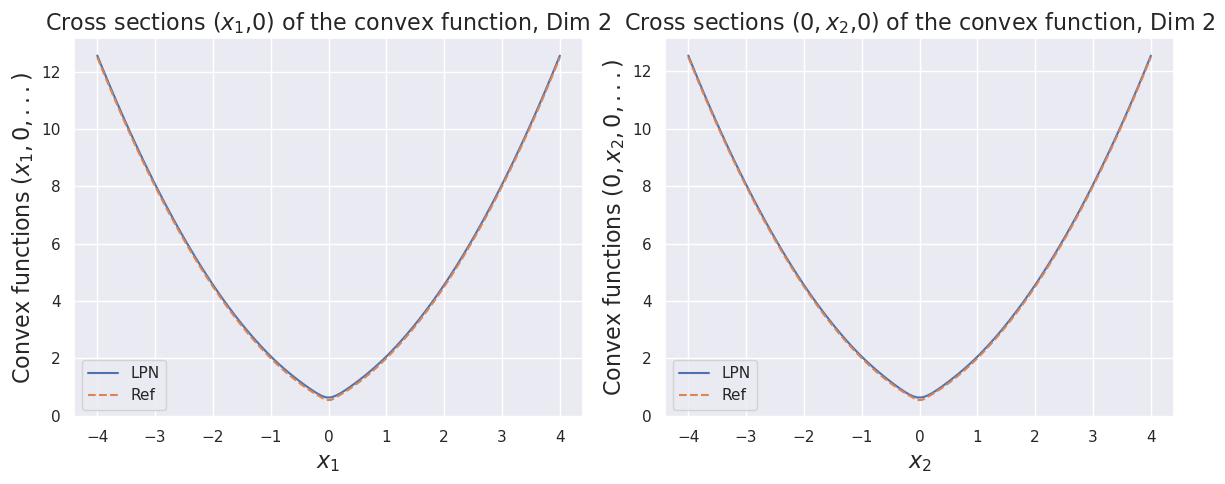

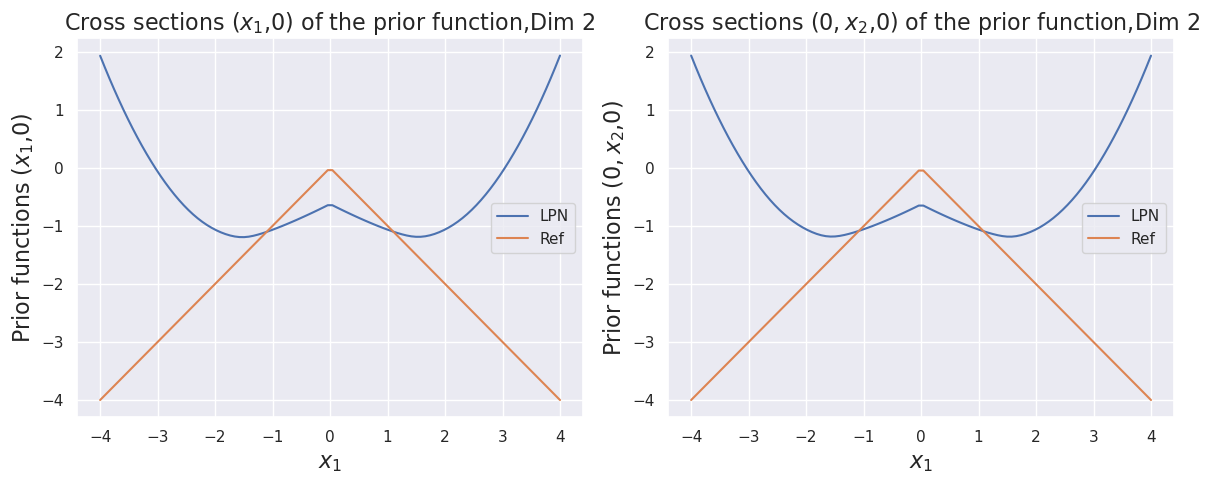

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 36.85958480834961
iteration 0 loss 2169.788818359375


iteration 5000 loss 0.002910790266469121


iteration 10000 loss 0.0007917114999145269


iteration 15000 loss 0.02048409730195999


iteration 20000 loss 0.00036229914985597134


iteration 25000 loss 0.0003399466222617775


iteration 30000 loss 0.0002483344287611544


iteration 35000 loss 0.00019431950931902975


iteration 40000 loss 0.00015422400610987097


iteration 45000 loss 0.004531423561275005


iteration 50000 loss 0.000113321264507249


iteration 55000 loss 0.00010276144166709855


iteration 60000 loss 0.034400567412376404


iteration 65000 loss 9.063456673175097e-05


iteration 70000 loss 8.64495596033521e-05


iteration 75000 loss 0.011990821920335293


iteration 80000 loss 6.878841668367386e-05


iteration 85000 loss 5.776196485385299e-05


iteration 90000 loss 6.975982250878587e-05


iteration 95000 loss 7.530035509262234e-05


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 4.86061762785539e-05


iteration 105000 loss 3.973728234996088e-05


iteration 110000 loss 3.228256173315458e-05


iteration 115000 loss 2.8024329367326573e-05


iteration 120000 loss 2.5001540052471682e-05


iteration 125000 loss 2.2668045858154073e-05


iteration 130000 loss 2.079222394968383e-05


iteration 135000 loss 1.930076723510865e-05


iteration 140000 loss 1.807985063351225e-05


iteration 145000 loss 1.6985855836537667e-05


iteration 150000 loss 1.6052639693953097e-05


iteration 155000 loss 1.5259816791513003e-05


iteration 160000 loss 1.464702290832065e-05


iteration 165000 loss 1.3933646187069826e-05


iteration 170000 loss 1.3401606338447891e-05


iteration 175000 loss 1.3038339602644555e-05


iteration 180000 loss 1.2353179954516236e-05


iteration 185000 loss 1.5574569260934368e-05


iteration 190000 loss 0.0001287468330701813


iteration 195000 loss 1.1056728908442892e-05


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 1.070965936378343e-05


iteration 205000 loss 1.0537249181652442e-05


iteration 210000 loss 1.0217451745120343e-05


iteration 215000 loss 9.934435183822643e-06


iteration 220000 loss 9.663251148595009e-06


iteration 225000 loss 9.414691703568678e-06


iteration 230000 loss 9.185613635054324e-06


iteration 235000 loss 8.978947334981058e-06


iteration 240000 loss 8.777217772149015e-06


iteration 245000 loss 8.587191587139387e-06


iteration 250000 loss 8.406617780565284e-06


iteration 255000 loss 9.823945219977759e-06


iteration 260000 loss 8.092273674265016e-06


iteration 265000 loss 7.950396138767246e-06


iteration 270000 loss 7.814136552042328e-06


iteration 275000 loss 7.686006938456558e-06


iteration 280000 loss 7.561829534097342e-06


iteration 285000 loss 7.4392719398019835e-06


iteration 290000 loss 7.518541679019108e-06


iteration 295000 loss 7.2281036409549415e-06


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 7.129980531317415e-06


iteration 305000 loss 7.098364676494384e-06


iteration 310000 loss 7.002051916060736e-06


iteration 315000 loss 6.906247108418029e-06


iteration 320000 loss 6.8148151513014454e-06


iteration 325000 loss 6.7320688685867935e-06


iteration 330000 loss 6.649338502029423e-06


iteration 335000 loss 6.570913683390245e-06


iteration 340000 loss 6.493693490483565e-06


iteration 345000 loss 6.420062163670082e-06


iteration 350000 loss 6.3523125390929636e-06


iteration 355000 loss 6.288020813371986e-06


iteration 360000 loss 6.224375738383969e-06


iteration 365000 loss 6.162223598948913e-06


iteration 370000 loss 6.102400220697746e-06


iteration 375000 loss 6.0450329328887165e-06


iteration 380000 loss 5.9884414440602995e-06


iteration 385000 loss 5.931010946369497e-06


iteration 390000 loss 5.876013347005937e-06


iteration 395000 loss 5.825681910209823e-06


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 5.7768165788729675e-06


iteration 405000 loss 5.766445610788651e-06


iteration 410000 loss 5.7160077631124295e-06


iteration 415000 loss 5.663431238644989e-06


iteration 420000 loss 5.6127746574929915e-06


iteration 425000 loss 5.56182385480497e-06


iteration 430000 loss 5.512263214768609e-06


iteration 435000 loss 5.465813956107013e-06


iteration 440000 loss 5.420717116066953e-06


iteration 445000 loss 5.37614687345922e-06


iteration 450000 loss 5.330972271622159e-06


iteration 455000 loss 5.28708687852486e-06


iteration 460000 loss 5.245725787972333e-06


iteration 465000 loss 5.204974058869993e-06


iteration 470000 loss 5.1655970310093835e-06


iteration 475000 loss 5.127667918713996e-06


iteration 480000 loss 5.090434569865465e-06


iteration 485000 loss 5.05509206050192e-06


iteration 490000 loss 5.019498530600686e-06


iteration 495000 loss 4.9846044021251146e-06


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


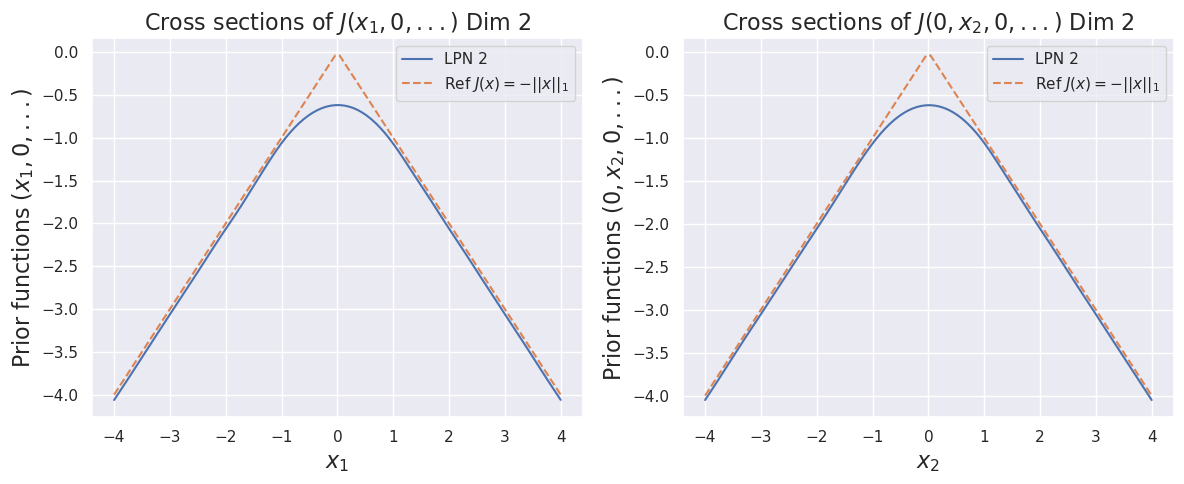

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('Prior functions $(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('Prior functions $(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)